# NoVaS

This notebook contains the results of volatlity forecasting with the NoVaS transformation (see Politis 2007) on S&P500 returns.

Regular ARCH model is expressed as $\frac{Y_t}{\sqrt{a + \sum_{i=1}^{p} a_i Y^{2}_{t-i}}}$

NoVaS is a slight improvement where we include the value of $Y_t$ from an empirical causal estimate of the standard deviation of $Y_t$. Hence, we may define the new "studentized" quantity as 

$$ W_{t,a} = \frac{Y_t}{\sqrt{\alpha s^2_{t-1} + a_0 Y^2_{t} + \sum_{i=1}^{p} a_i Y^2_{t-i}}} $$

Algorithm for Simple NoVaS:

- Let $\alpha=0$ and $a_i = \frac{1}{p+1}$ for all $ 0 \leq i \leq p$
- Pick $p$ such that $|KURT_{n}(W_{t,p}^{S}) - 3 |$ is minimized

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kurtosis

In [2]:
# data read in, adjustment and conversion to returns
sp500_data = pd.read_csv("./data/sp500index.csv")
sp500_data.index = sp500_data["Date"].astype('datetime64[ns]')
sp500_data.drop(columns=['Date'],inplace=True)

# convert to returns and normalize returns
sp500_returns = sp500_data['Close'].pct_change()[1:]
sp500_returns = (sp500_returns - np.mean(sp500_returns))/np.std(sp500_returns) # normalize to have mean 0 std 1

## S&P 500 Returns Exploration

In [3]:
# testing kurtosis functions
scipy_kurtosis = kurtosis(sp500_returns, fisher=False)
print("Scipy version:", scipy_kurtosis)

Scipy version: 23.849598711166028


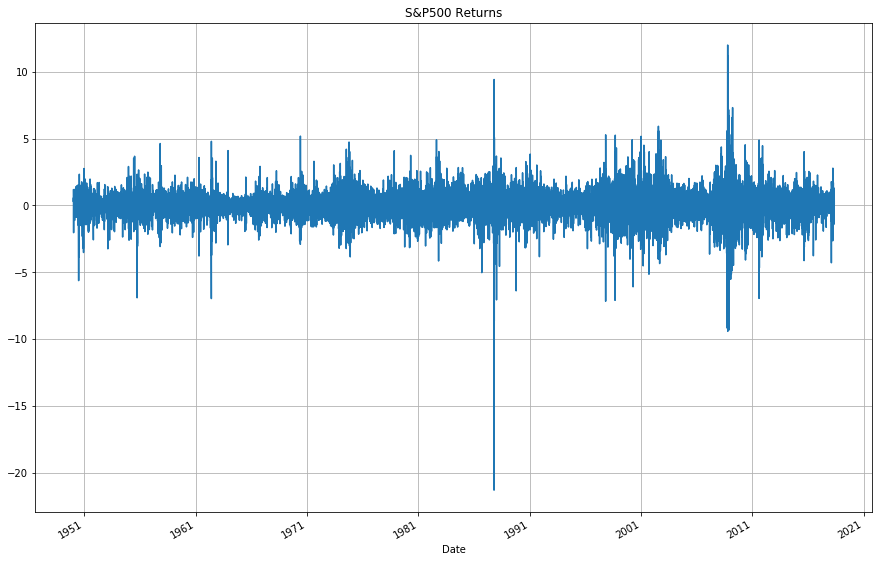

In [4]:
sp500_returns.plot(title='S&P500 Returns',grid=True, figsize=(15, 10));

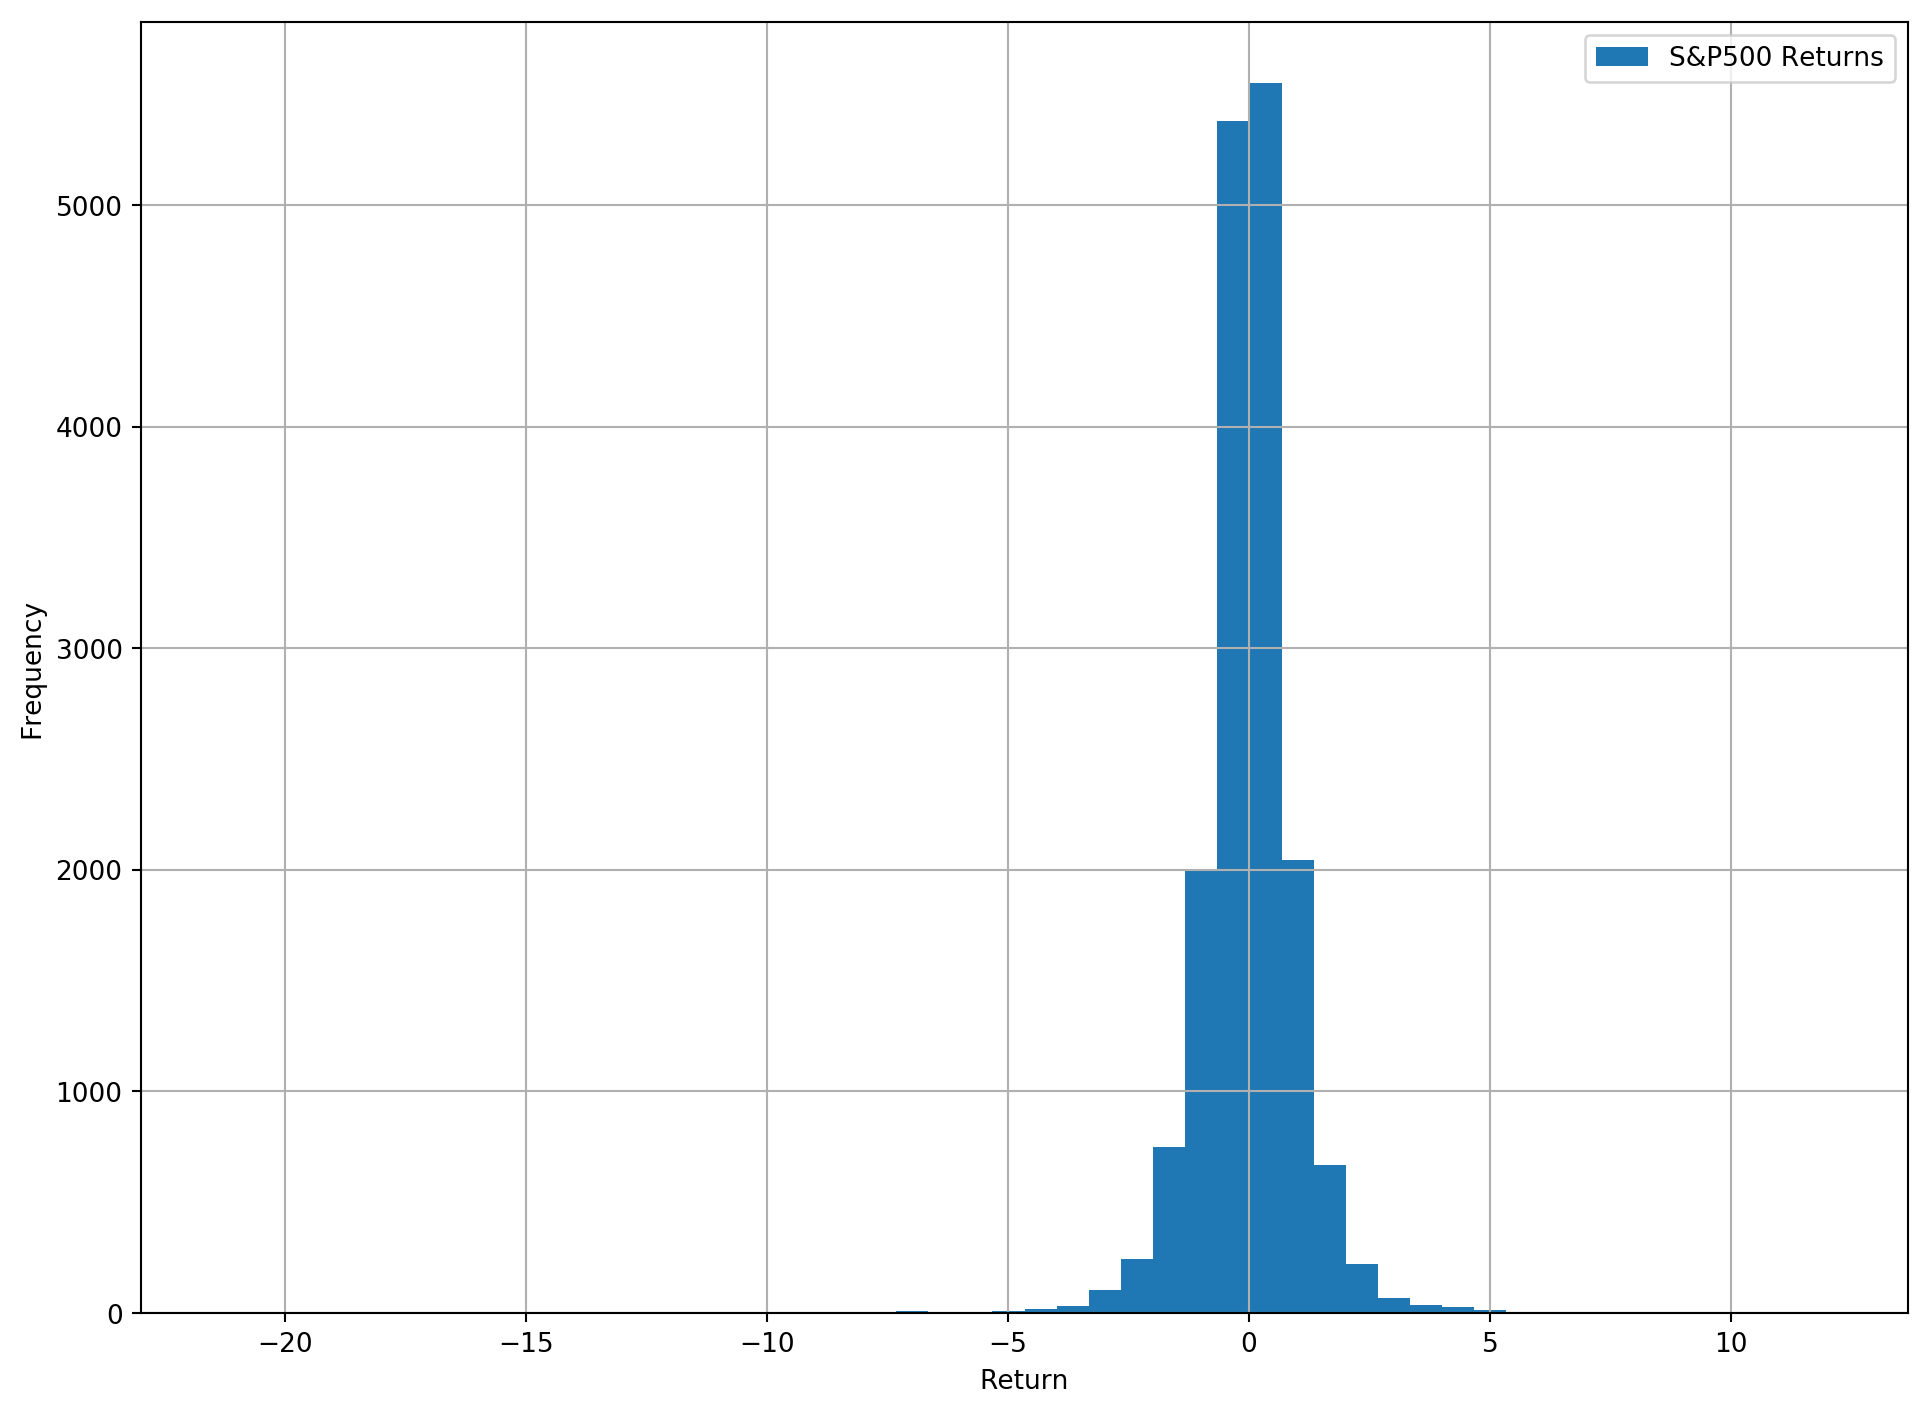

In [5]:
plt.figure(figsize=(12, 9), dpi=190)
plt.hist(sp500_returns, bins=50)
plt.grid(True)
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend(['S&P500 Returns']);

In [6]:
# figuring out the default blue for pyplot
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


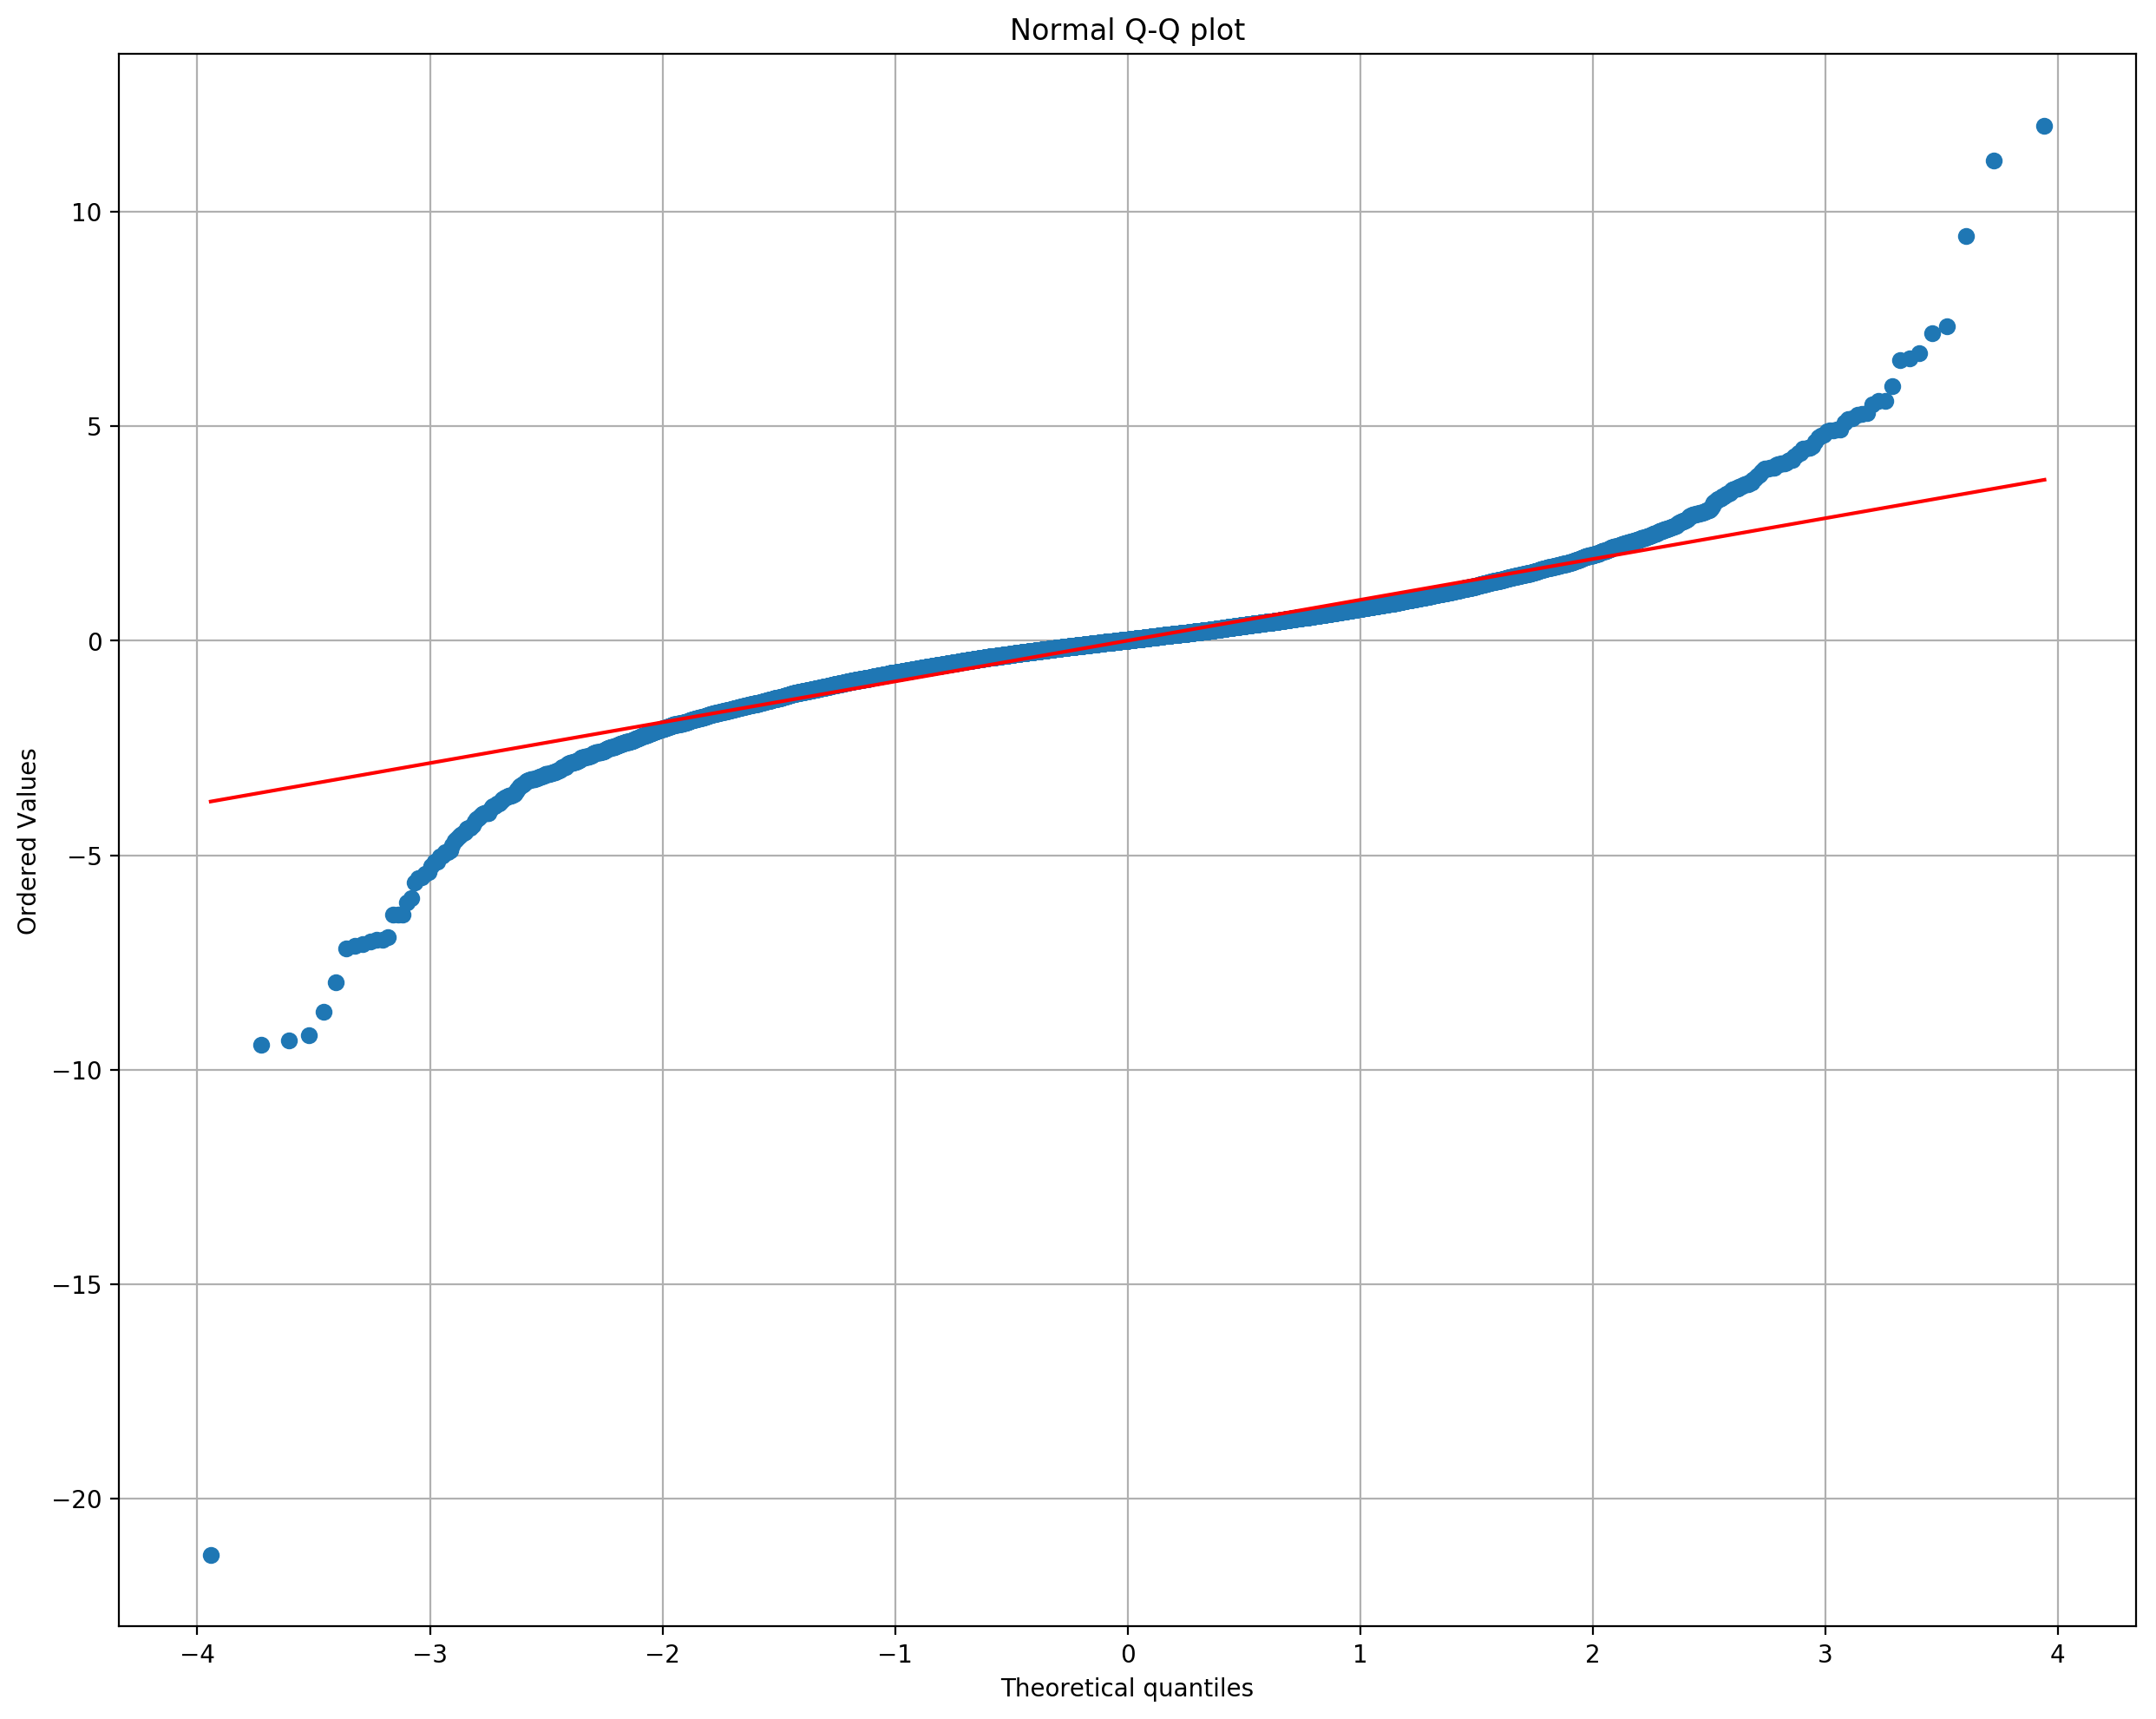

In [7]:
fig = plt.figure(figsize=(15, 12), dpi=200)
ax = fig.add_subplot(111)
stats.probplot(sp500_returns, dist="norm", plot=plt)
plt.grid(True)
plt.title("Normal Q-Q plot")

ax.get_lines()[0].set_markerfacecolor('#1f77b4') # adjusted to match default pyplot blue
ax.get_lines()[0].set_markeredgecolor('#1f77b4') # adjusted to match default pyplot blue
plt.savefig('sp500_returns_qqplot.png')
plt.show();

All three plots above suggest as expected that the S&P500 returns data does not come from a normal distribution. We further confirm this by calculating the kurtosis over the entire time series.

## Simple NoVaS Transform

We implement the simple NoVaS transform outlined above and select a lag parameter p that results in the transforming the data to a normal distribution. We confirm this by plotting the diagrams above for the transformed series $W_t$


In [9]:
def simple_novas(returns, p):
    """
    Function performs NoVaS (normalizing and variance stabilizing transformation) on financial returns series
    as outlined in Politis (2007)
    
    input:
        returns - daily financial returns
        p - lag parameter (first p-1 entries of o)
    output:
        W_t - NoVaS transformed series
    """
    
    n = len(returns)
    X_t = np.zeros(2*p+n) # placeholder vector containing returns upto period t
    X_t[2*p:2*p+n] = returns
    X_t = pd.Series(X_t)
    
    # to calculate denominator term, sum lag p squared returns
    lagged_squared_returns = pd.Series(np.zeros(len(X_t))) 
    for i in range(p):
        lagged_squared_returns = lagged_squared_returns + (X_t**2).shift(-i)
    
    W_t = X_t/np.sqrt(lagged_squared_returns/p)
    W_t = W_t[2*p:2*p+n] # drop extra lag indices in array
    W_t = W_t.dropna() # drop 
    return W_t

In [10]:
W_t = simple_novas(sp500_returns,16)
W_t.index = sp500_returns.index[15:]
kurtosis(W_t, fisher=False) # using pearson definition where Normal kurtosis = 3

3.0215729106043225

In [11]:
# Sample values from a normal distribution
X2 = np.random.normal(0, 1, 9000)

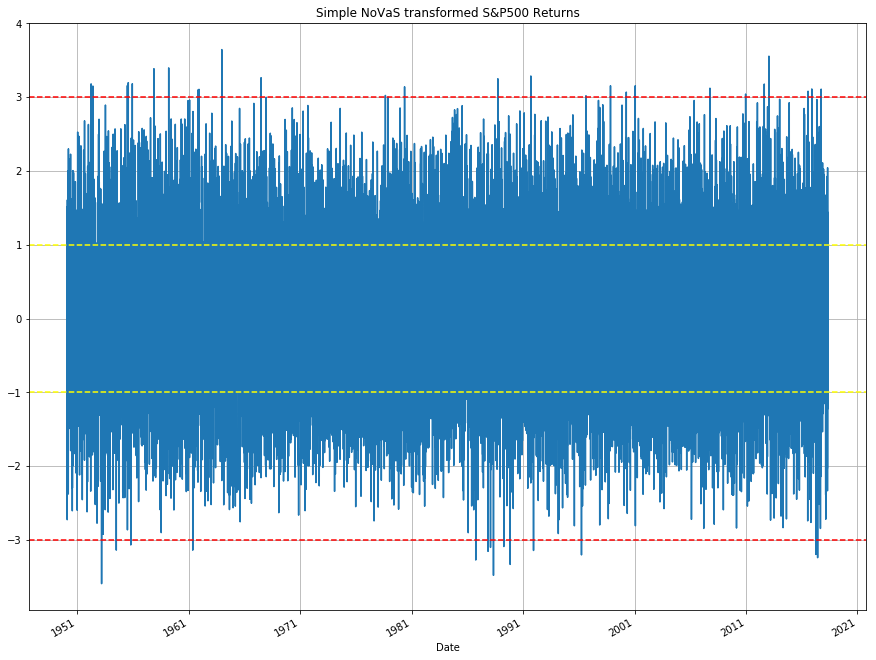

In [12]:
W_t.plot(title='Simple NoVaS transformed S&P500 Returns',grid=True, figsize=(15, 12))
plt.axhline(X2.std(), color='yellow', linestyle='--')
plt.axhline(-X2.std(), color='yellow', linestyle='--')
plt.axhline(3*X2.std(), color='red', linestyle='--')
plt.axhline(-3*X2.std(), color='red', linestyle='--')
plt.savefig('novas_sp500_returns.png');

Clearly returns above look to have been normalized by the transformation as there are no major outliners to be found

In [12]:
# check constraint 10.13 in chapter 10 is satisfied
a0 = 1/16
constraint_check = a0 <= 1/9
print(constraint_check)

True


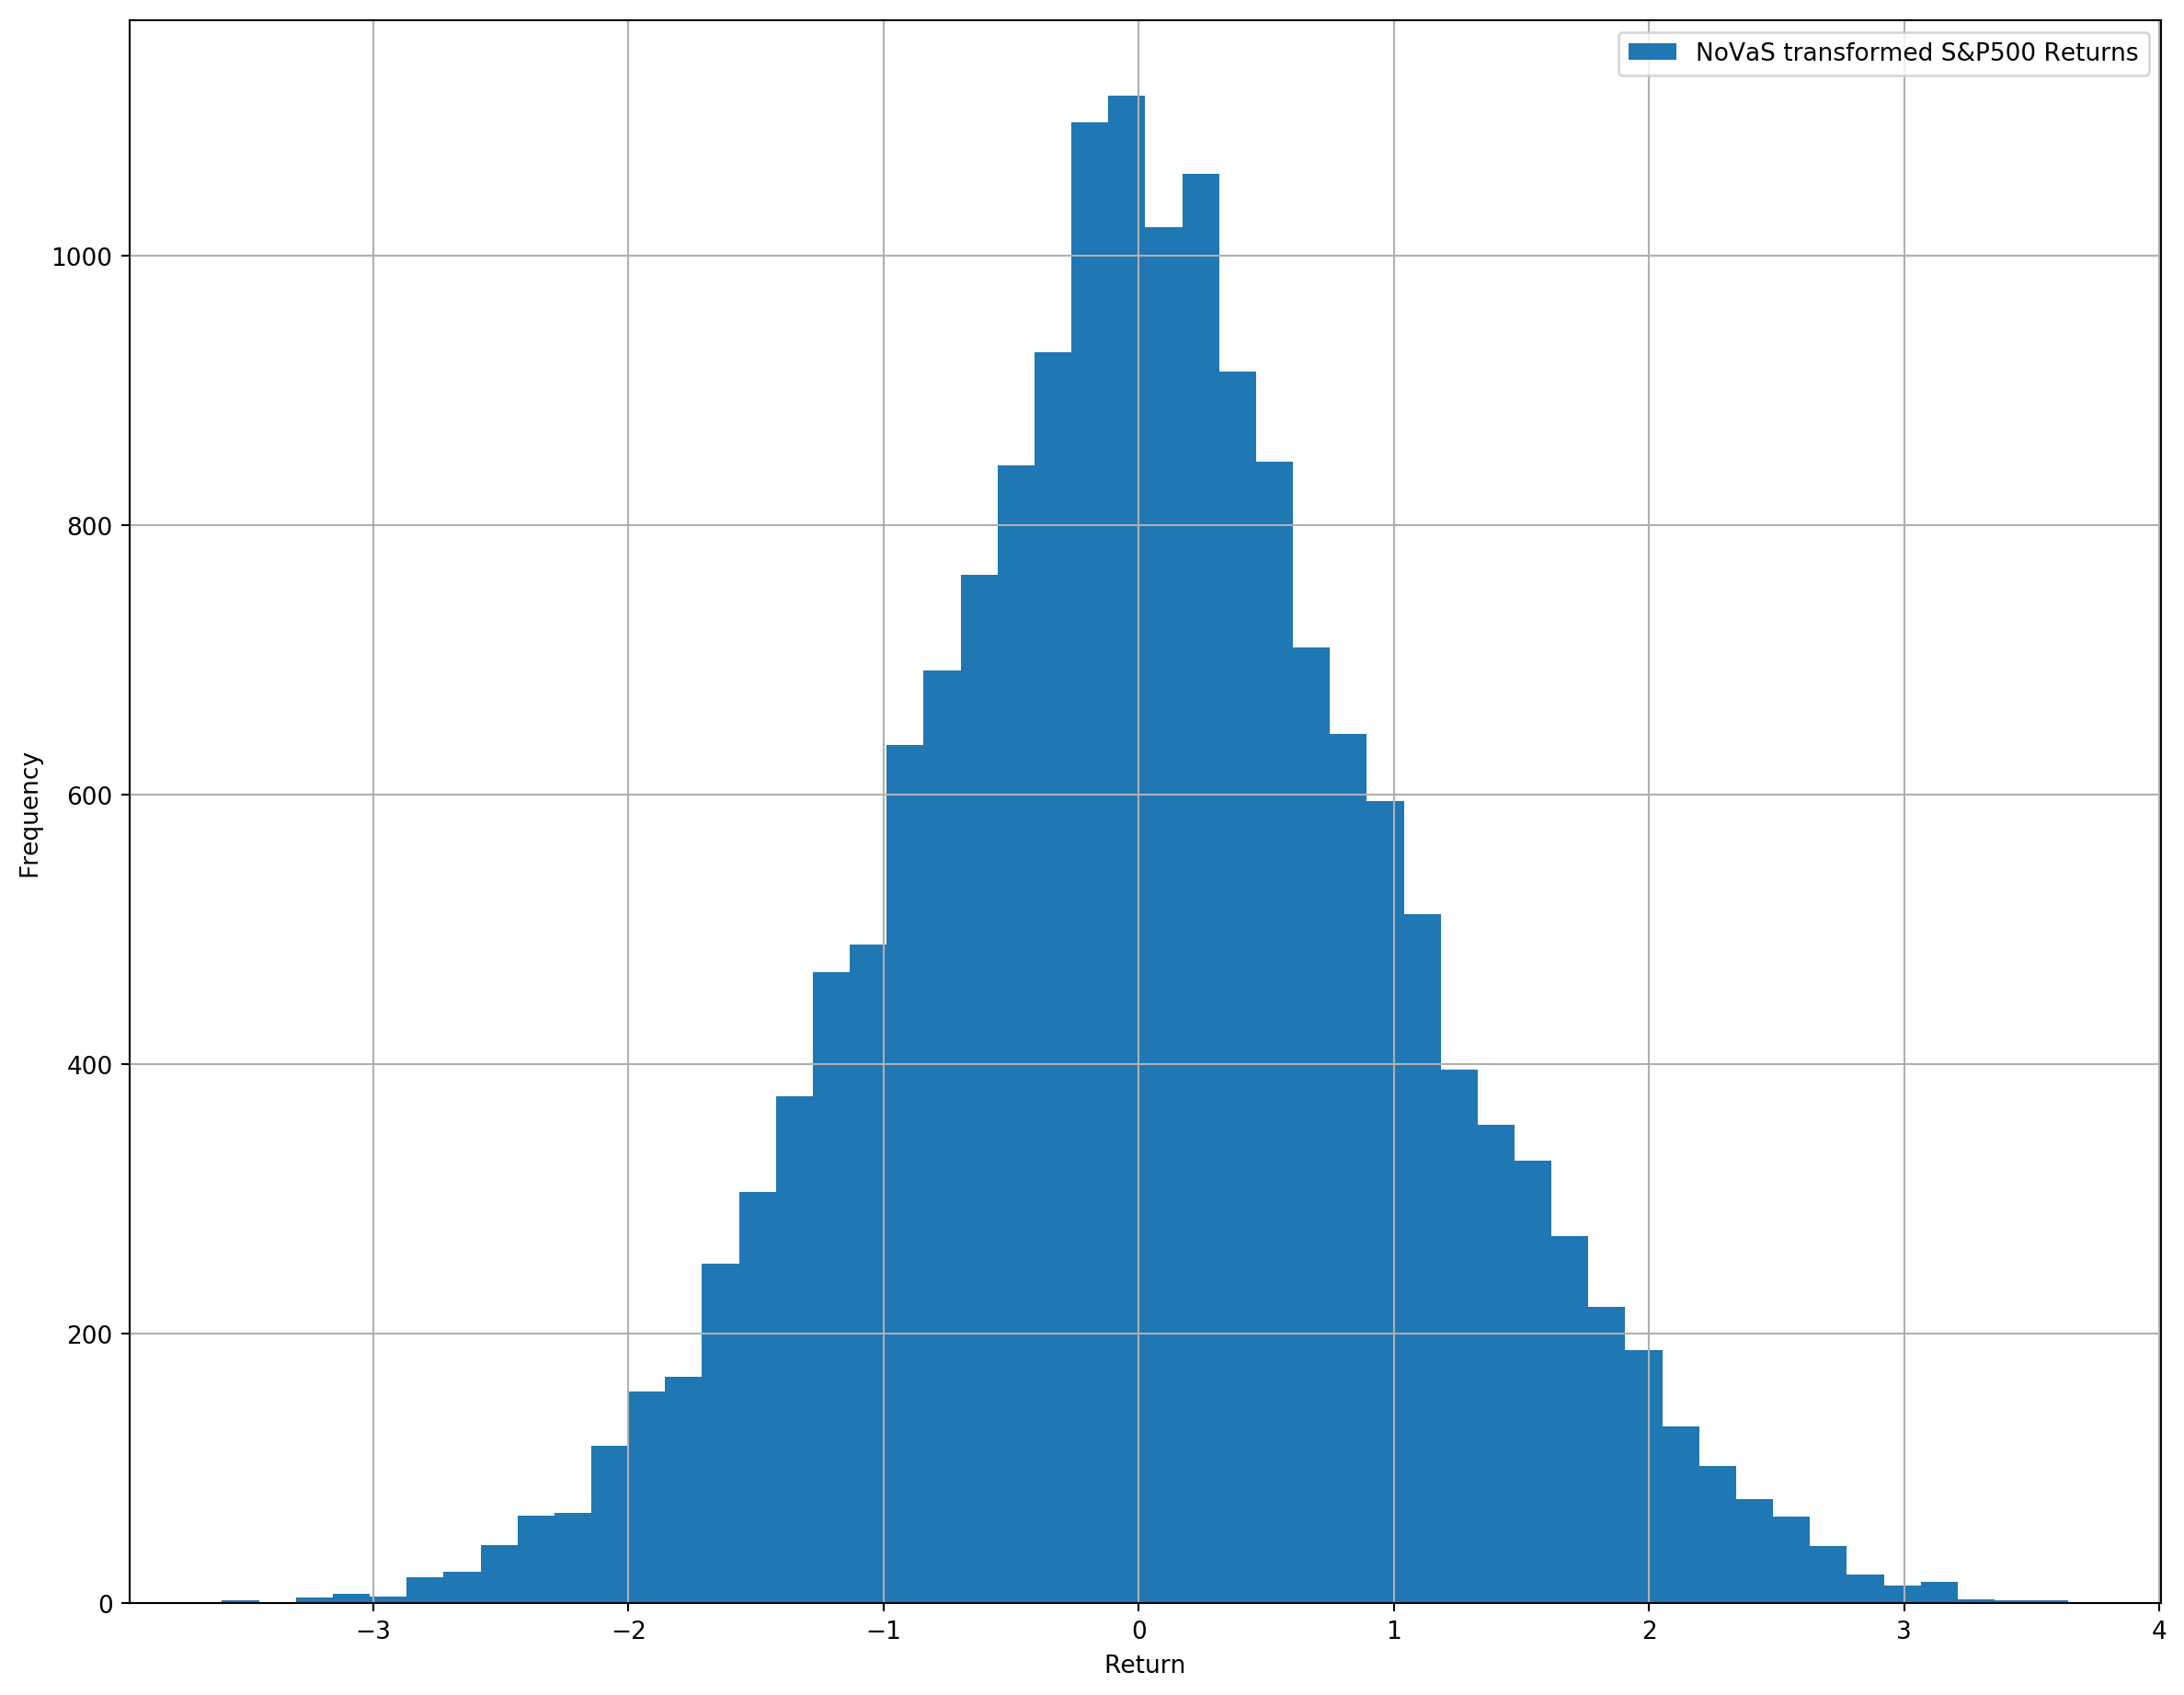

In [13]:
plt.figure(figsize=(15, 12), dpi=190)
plt.hist(W_t, bins=50)
plt.grid(True)
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend(['NoVaS transformed S&P500 Returns'])
plt.savefig('novas_sp500_returns_hist.png');

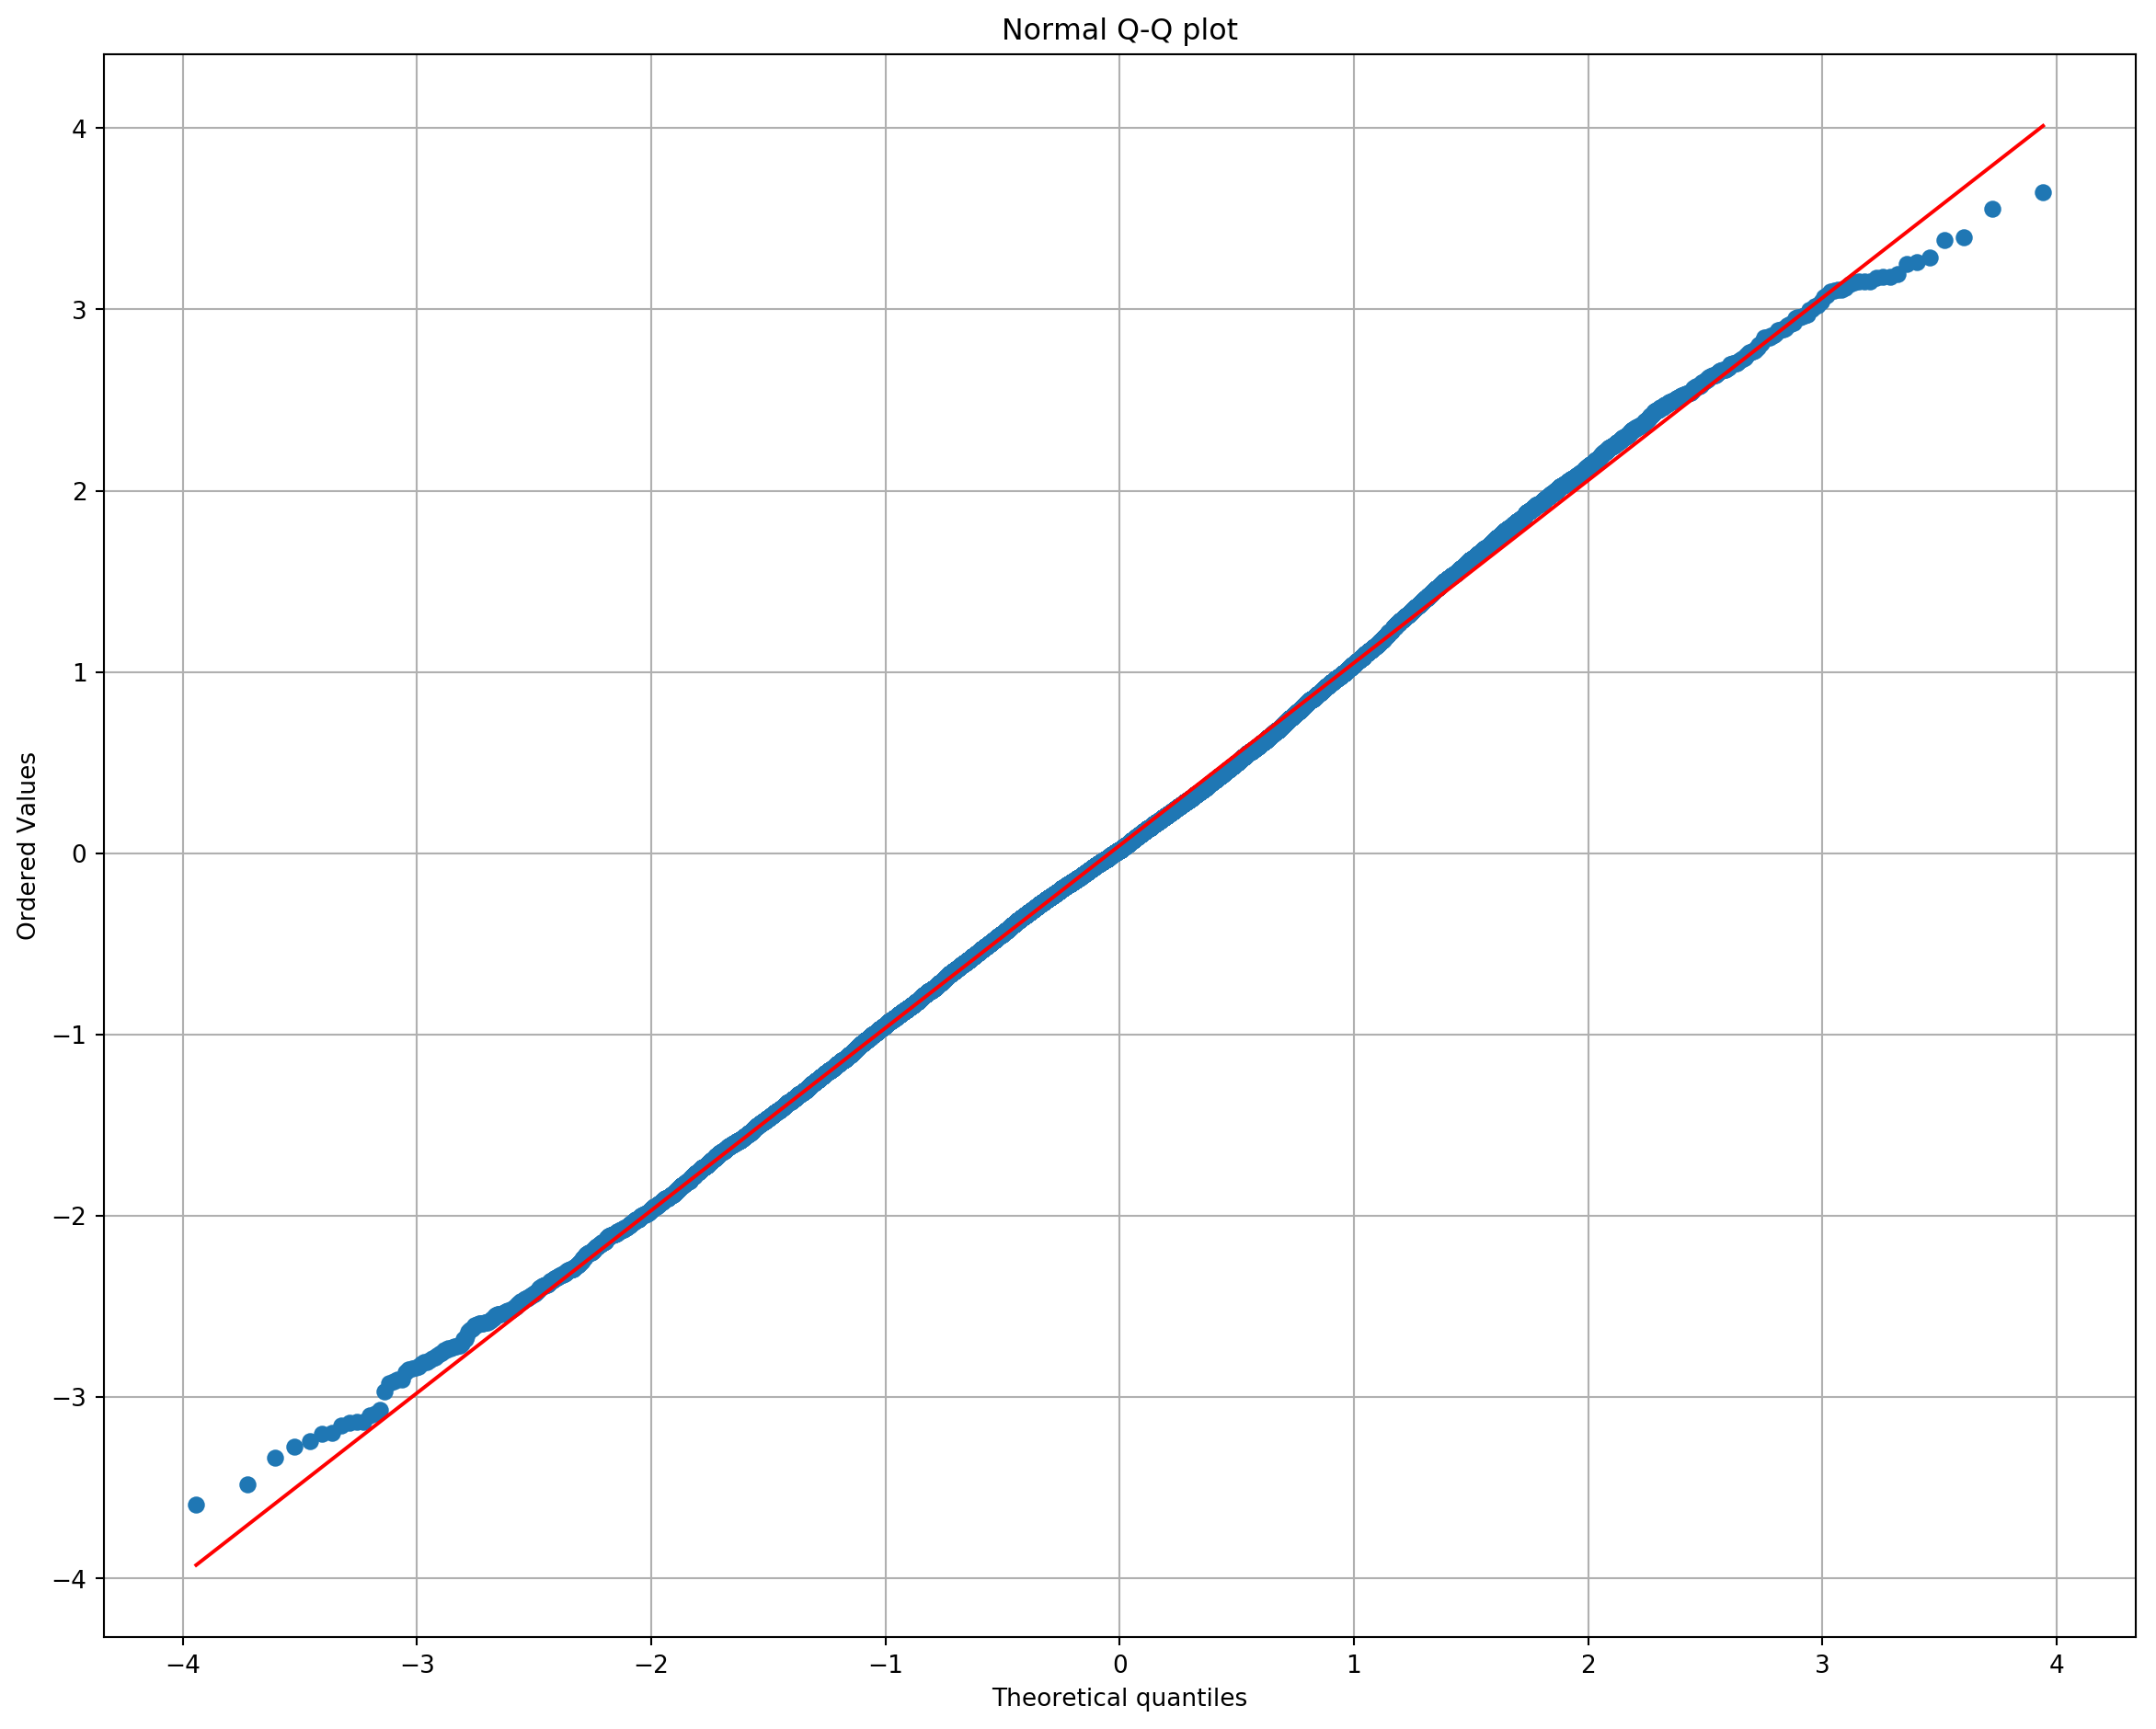

In [14]:
fig = plt.figure(figsize=(15, 12), dpi=190)
ax = fig.add_subplot(111)
stats.probplot(W_t, dist="norm", plot=plt)
plt.grid(True)
plt.title("Normal Q-Q plot")
ax.get_lines()[0].set_markerfacecolor('#1f77b4')
ax.get_lines()[0].set_markeredgecolor('#1f77b4')
plt.savefig('novas_sp500_returns_qqplot.png')
plt.show();

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


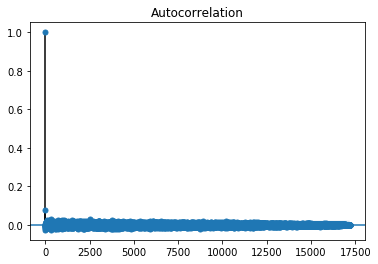

In [16]:
plot_acf(W_t);

Acf plot above suggests that transformed series satisfies case 1 that $W_t$ appears to be uncorrelated and also indepedent. As a result we can predict $Y_{n+1}^2$ (under $L_1$ loss) by

$$ Y_{n+1}^2 = \hat{\mu_2}A_{n}^2 $$

where

$$ \hat{\mu_2} = median \{ \frac{W_{t,a}^2}{1-a_0W_{t,a}^2} ; t = p+1, p+2, \dots, n\} $$

and

$$ A_{n}^2 = \sqrt{\alpha s^2_{t-1} + \sum_{i=1}^{p} a_i Y^2_{t-i}} $$


In [17]:
def simple_novas_prediction(returns, p):
    """
    Function performs NoVaS (normalizing and variance stabilizing transformation) on financial returns series
    as outlined in Politis (2007) and then compute the optimal one-step ahead L1 prediction
    
    input:
        returns - daily financial returns
        p - lag parameter (first p-1 entries of o)
    output:
        W_t - NoVaS transformed series
    """
    
    ## NoVaS transform
    
    n = len(returns)
    X_t = np.zeros(2*p+n) # placeholder vector containing returns upto period t
    X_t[2*p:2*p+n] = returns
    X_t = pd.Series(X_t)
    
    # to calculate denominator term, sum lag p squared returns
    lagged_squared_returns = pd.Series(np.zeros(len(X_t))) 
    for i in range(p):
        lagged_squared_returns = lagged_squared_returns + (X_t**2).shift(-i)
    
    W_t = X_t/np.sqrt(lagged_squared_returns/p)
    W_t = W_t[2*p:2*p+n] # drop extra lag indices in array
    W_t = W_t.dropna() # drop 
    
    # L1 prediction
    
    An2 = (lagged_squared_returns/p)
    An2 = An2[2*p:2*p+n]
    An2 = An2.dropna()
    An2 = An2.iloc[-1]

    a0 = 1/p
    W2 = W_t**2/(1-a0*(W_t**2))
    mu2 = np.nanmedian(W2)
    predictor = mu2*An2
    
    return predictor

In [18]:
predictor = simple_novas_prediction(sp500_returns, 16)
predictor

0.2477919538534975

## 1987 Crash Prediction

In [24]:
pre_crash_date = '1987-10-16'
pre_crash_returns = sp500_returns[:pre_crash_date]

In [38]:
W_t_1987 = simple_novas(pre_crash_returns, 210)
kurtosis(W_t_1987)

3.012969028310642

In [39]:
# check constraint 10.13 in chapter 10 is satisfied
a0 = 1/210
constraint_check = a0 <= 1/9
print(constraint_check)

True


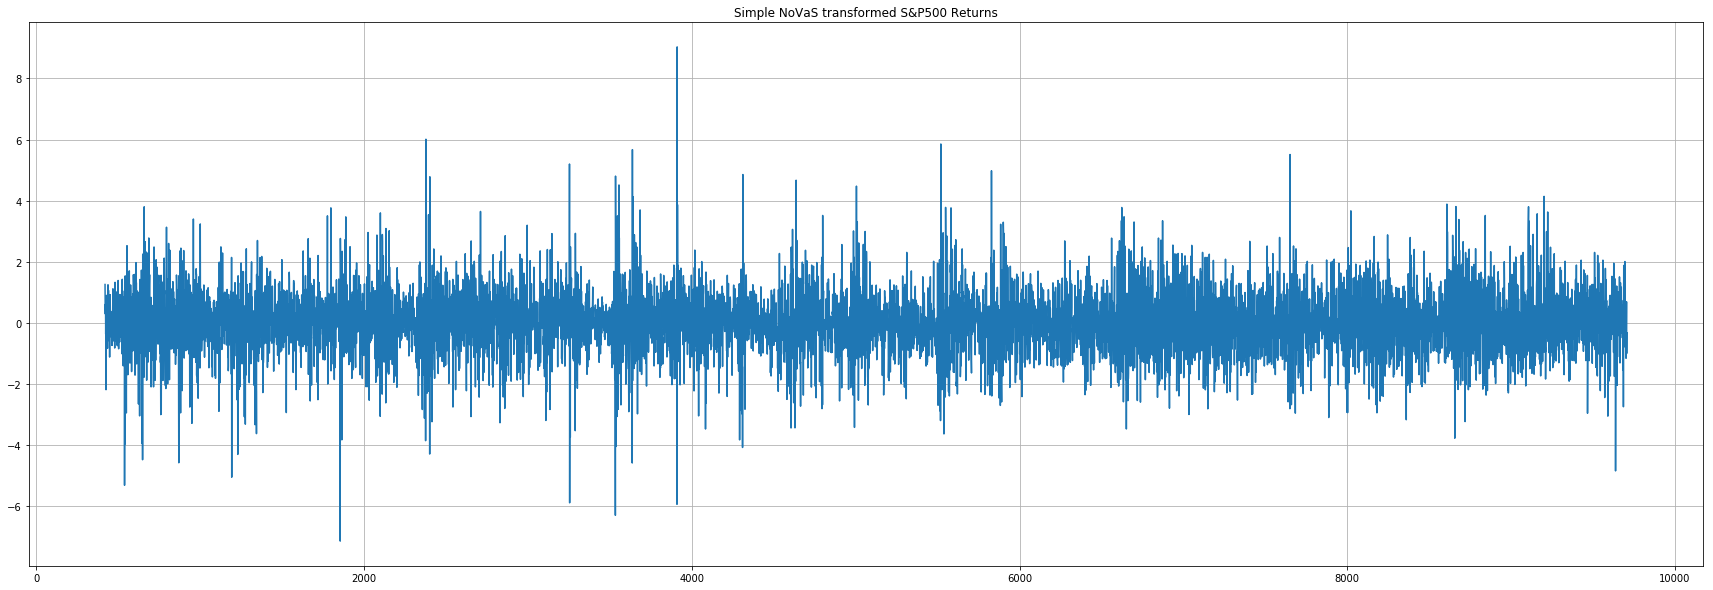

In [40]:
W_t_1987.plot(title='Simple NoVaS transformed S&P500 Returns',grid=True, figsize=(30, 10))

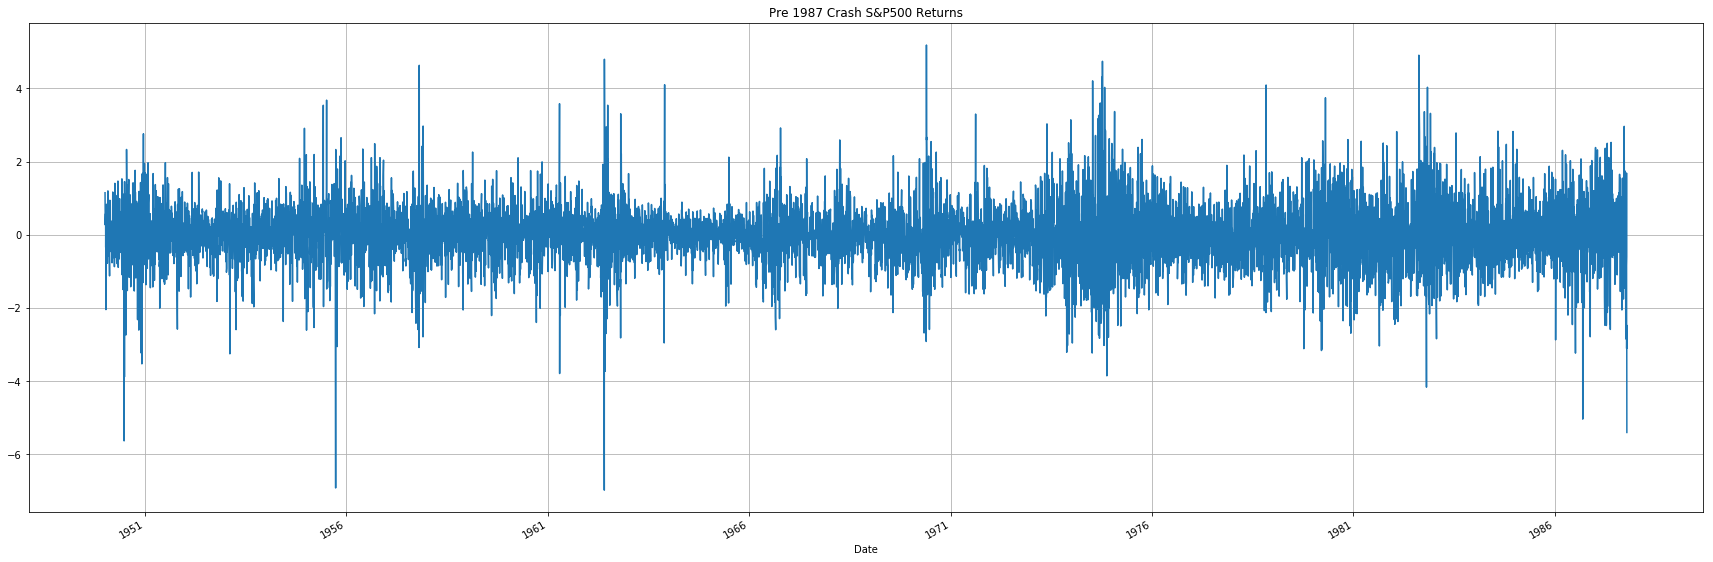

In [42]:
pre_crash_returns.plot(title='Pre 1987 Crash S&P500 Returns',grid=True, figsize=(30, 10))

## Estimating the volatility $\mathbb{E}(Y_{n+1}^2|\mathfrak{F_n})$

Under case I, i.e. after empirically showing that the $W_{t,a}$ variables are (approximately) uncorrelated and hence independent, it is straightforward to construct a Model-free estimate of the conditional expectation $\mathbb{E}(Y_{n+1}^2|\mathfrak{F_{n}})$.


$$\mathbb{E}(Y_{n+1}^2|\mathfrak{F_{n}}) = A_{n}^2 \mathbb{E} \bigg( \frac{W_{t,a}^2}{1-a_0 W_{t,a}^2} \bigg) $$

a natural estimate thereof is

$$ \frac{A_{n}^2}{n-p} \sum_{t=p+1}^{n} \bigg( \frac{W_{t,a}^2}{1-a_0 W_{t,a}^2} \bigg) $$


In [19]:
def real_vol_estimate(returns, p):
    
    """
    
    function calculates the realized volatility estimate in case I of NoVaS transform where the transformed
    variables are uncorrelated and independent.
    
    input:
        returns - daily financial returns
        p - lag parameter (first p-1 entries)
        
    output:
        real_vol_forecast - forecast of conditional variance
    
    """
    
    ## NoVaS transform
    
    n = len(returns)
    X_t = np.zeros(2*p+n) # placeholder vector containing returns upto period t
    X_t[2*p:2*p+n] = returns
    X_t = pd.Series(X_t)
    
    # to calculate denominator term, sum lag p squared returns
    lagged_squared_returns = pd.Series(np.zeros(len(X_t))) 
    for i in range(p):
        lagged_squared_returns = lagged_squared_returns + (X_t**2).shift(-i)
    
    W_t = X_t/np.sqrt(lagged_squared_returns/p)
    W_t = W_t[2*p:2*p+n] # drop extra lag indices in array
    W_t = W_t.dropna() # drop 
    
    # conditional variance forecast
    
    An2 = (lagged_squared_returns/p)
    An2 = An2[2*p:2*p+n]
    An2 = An2.dropna()
    An2 = An2.iloc[-1]

    a0 = 1/p
    W2 = W_t**2/(1-a0*(W_t**2))
    
    sum_term = sum(W2[p+1:])
    estimate = (An2/(n-p))*sum_term
    
    return estimate

In [20]:
temp = real_vol_estimate(sp500_returns, 16)

## BTC/USD